<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V7_CP_RFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [4]:
!pip show lightgbm | pip install lightgbm==4.6.0

In [5]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


In [7]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [10]:
# 📂 Cargar datos
file_path = (r"C:\Users\hamza\Downloads\260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx")
df = pd.read_excel(file_path)

In [12]:
# 🎯 Selección de variable objetivo
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = 'kgCP/ha'

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']


In [14]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [17]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 1104.761648


# 📈 Basic Models Evaluation

In [20]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.8511736973681335
RMSE: 91.73168798817501
MAE: 66.78905398239343
MAPE: 6.956258101460598

XGBoost Basic
R2: 0.8281225034971249
RMSE: 98.58005329241811
MAE: 71.9091154953529
MAPE: 7.388331100596887

AdaBoost Basic
R2: 0.6940982683211769
RMSE: 131.51355171859294
MAE: 103.49091144797389
MAPE: 10.366018404702174

Random Forest Basic
R2: 0.8290591120085196
RMSE: 98.31109124974414
MAE: 72.63793103448276
MAPE: 7.565432468696096


### Variable importance for RMS global reduction

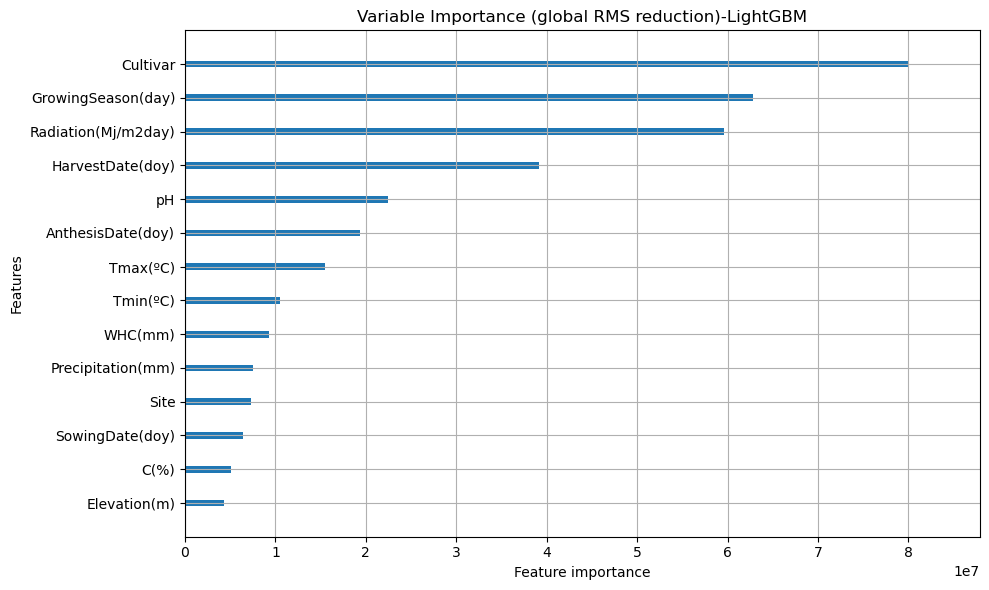

In [22]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

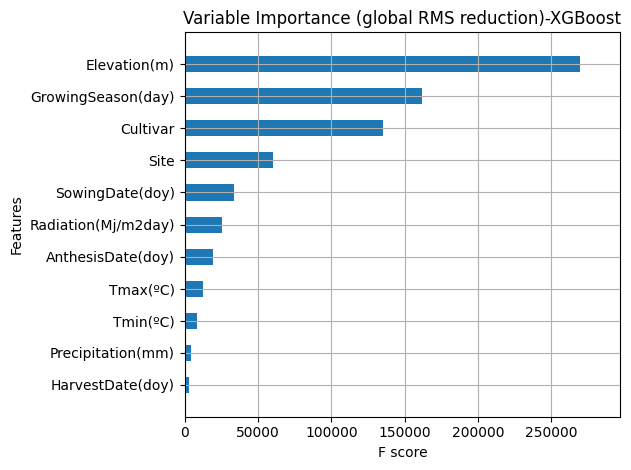

In [10]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

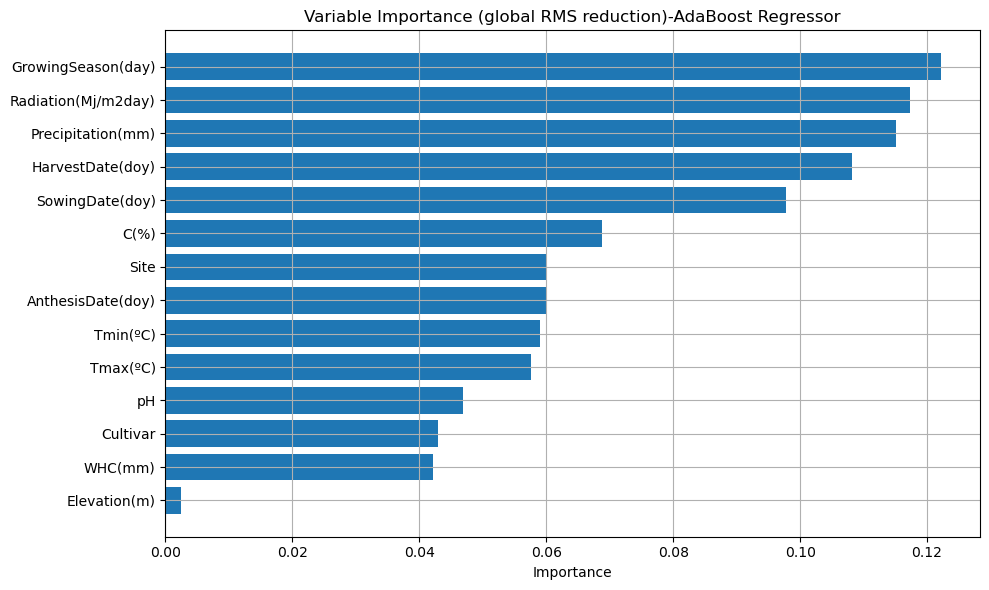

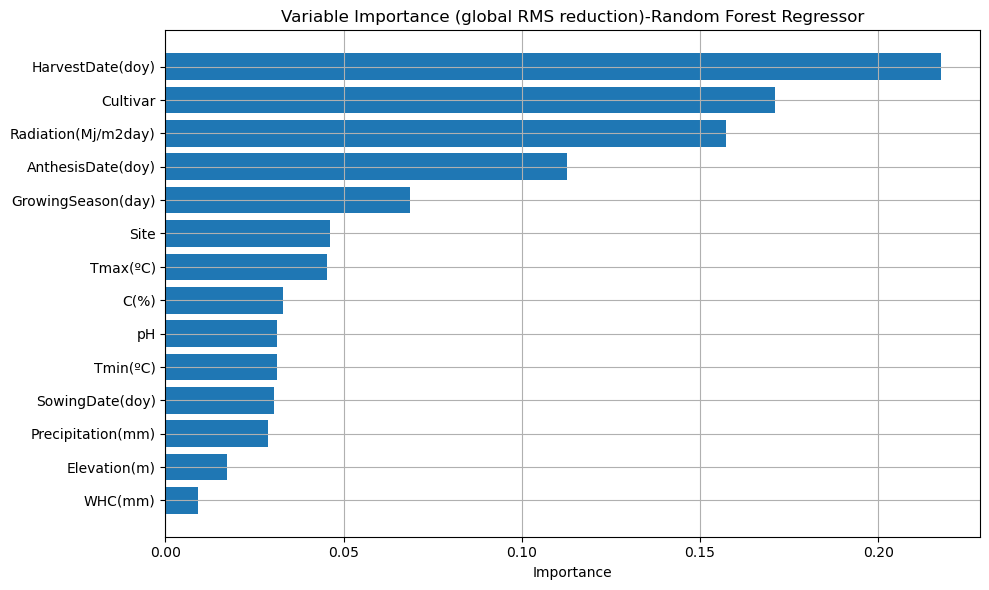

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [26]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-08-15 23:03:25,499] A new study created in memory with name: no-name-bf5691dc-330a-432a-b228-0be36e41c98c
[I 2025-08-15 23:03:25,638] Trial 0 finished with value: 99.72592515490528 and parameters: {'learning_rate': 0.1102244199202943, 'num_leaves': 200, 'max_depth': 7, 'min_child_samples': 76, 'subsample': 0.6771548778775127, 'colsample_bytree': 0.9471981988053806}. Best is trial 0 with value: 99.72592515490528.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:25,822] Trial 1 finished with value: 94.65892210565818 and parameters: {'learning_rate': 0.12513543445431488, 'num_leaves': 75, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.9444266559741619, 'colsample_bytree': 0.804888696546096}. Best is trial 1 with value: 94.65892210565818.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:25,969] Trial 2 finished with value: 97.41028713892157 and parameters: {'learning_rate': 0.22897086996515936, 'num_leaves': 188, 'max_depth': 8, 'min_child_samples': 42, 'subsample': 0.9161099218166922, 'colsample_bytree': 0.7864135571032272}. Best is trial 1 with value: 94.65892210565818.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:26,172] Trial 3 finished with value: 95.89975030479357 and parameters: {'learning_rate': 0.28614597463277563, 'num_leaves': 86, 'max_depth': 14, 'min_child_samples': 28, 'subsample': 0.6997604974297901, 'colsample_bytree': 0.940077562798247}. Best is trial 1 with value: 94.65892210565818.
[I 2025-08-15 23:03:26,311] Trial 4 finished with value: 93.35868967083226 and parameters: {'learning_rate': 0.141085109541353, 'num_leaves': 26, 'max_depth': 6, 'min_child_samples': 19, 'subsample': 0.6627923862744991, 'colsample_bytree': 0.8200775125213255}. Best is trial 4 with value: 93.35868967083226.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:26,455] Trial 5 finished with value: 96.06875607246205 and parameters: {'learning_rate': 0.18853591524062377, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.6700399280550728, 'colsample_bytree': 0.6084269891930963}. Best is trial 4 with value: 93.35868967083226.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:26,559] Trial 6 finished with value: 93.00244782002798 and parameters: {'learning_rate': 0.18291939221604672, 'num_leaves': 77, 'max_depth': 4, 'min_child_samples': 18, 'subsample': 0.5310830893905819, 'colsample_bytree': 0.9803897987173411}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:26,675] Trial 7 finished with value: 98.85166183810816 and parameters: {'learning_rate': 0.23231513327984246, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 74, 'subsample': 0.7549859677327729, 'colsample_bytree': 0.9913865095631176}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:26,807] Trial 8 finished with value: 99.26659481882943 and parameters: {'learning_rate': 0.18509680974030518, 'num_leaves': 138, 'max_depth': 11, 'min_child_samples': 69, 'subsample': 0.9990726581967865, 'colsample_bytree': 0.9870342773616574}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:26,931] Trial 9 finished with value: 99.47081258772299 and parameters: {'learning_rate': 0.14449712823436944, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 81, 'subsample': 0.5884279079451696, 'colsample_bytree': 0.7530912284415527}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1104.389159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:27,065] Trial 10 finished with value: 123.35715689437981 and parameters: {'learning_rate': 0.03353671387538844, 'num_leaves': 131, 'max_depth': 3, 'min_child_samples': 9, 'subsample': 0.5180961166536866, 'colsample_bytree': 0.504036130584314}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:27,203] Trial 11 finished with value: 95.00443852854656 and parameters: {'learning_rate': 0.07923055313140892, 'num_leaves': 33, 'max_depth': 4, 'min_child_samples': 6, 'subsample': 0.5518714352855899, 'colsample_bytree': 0.8658512776887484}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:27,322] Trial 12 finished with value: 108.53657330282786 and parameters: {'learning_rate': 0.06935617700531924, 'num_leaves': 21, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.6061205328543219, 'colsample_bytree': 0.66236510115386}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:27,569] Trial 13 finished with value: 93.41904702102099 and parameters: {'learning_rate': 0.1808097232894324, 'num_leaves': 58, 'max_depth': 5, 'min_child_samples': 18, 'subsample': 0.8156581686101145, 'colsample_bytree': 0.8776038195581667}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:27,704] Trial 14 finished with value: 99.21879479265758 and parameters: {'learning_rate': 0.2315351120462694, 'num_leaves': 51, 'max_depth': 6, 'min_child_samples': 53, 'subsample': 0.510120186624214, 'colsample_bytree': 0.6706096896794725}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:27,819] Trial 15 finished with value: 100.89141503980505 and parameters: {'learning_rate': 0.1519564169389616, 'num_leaves': 113, 'max_depth': 3, 'min_child_samples': 49, 'subsample': 0.6220115850205405, 'colsample_bytree': 0.8433850840135674}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:28,031] Trial 16 finished with value: 93.70658405783445 and parameters: {'learning_rate': 0.09934283202171165, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 19, 'subsample': 0.8162383134284665, 'colsample_bytree': 0.9040006951411885}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 1104.350754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:28,194] Trial 17 finished with value: 138.79853604089084 and parameters: {'learning_rate': 0.013035454201065666, 'num_leaves': 103, 'max_depth': 5, 'min_child_samples': 39, 'subsample': 0.7435918225192873, 'colsample_bytree': 0.6937140497974794}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:28,439] Trial 18 finished with value: 99.08779347358937 and parameters: {'learning_rate': 0.29281043212033275, 'num_leaves': 162, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.5751912733600544, 'colsample_bytree': 0.8147877136207123}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:28,578] Trial 19 finished with value: 99.80618371106898 and parameters: {'learning_rate': 0.20524209286661801, 'num_leaves': 62, 'max_depth': 6, 'min_child_samples': 59, 'subsample': 0.6408782564058365, 'colsample_bytree': 0.7357818809499522}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:28,726] Trial 20 finished with value: 97.84359548936219 and parameters: {'learning_rate': 0.2595650761613243, 'num_leaves': 107, 'max_depth': 4, 'min_child_samples': 24, 'subsample': 0.7299318110933014, 'colsample_bytree': 0.5914426455473798}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:28,879] Trial 21 finished with value: 94.20469143407016 and parameters: {'learning_rate': 0.1723141356901326, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 13, 'subsample': 0.8427940143546935, 'colsample_bytree': 0.8733807856408713}. Best is trial 6 with value: 93.00244782002798.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1104.389159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:29,014] Trial 22 finished with value: 96.77483335496886 and parameters: {'learning_rate': 0.13484815947745554, 'num_leaves': 63, 'max_depth': 4, 'min_child_samples': 36, 'subsample': 0.7988590416177277, 'colsample_bytree': 0.9239916346618378}. Best is trial 6 with value: 93.00244782002798.
[I 2025-08-15 23:03:29,182] Trial 23 finished with value: 92.54942571789246 and parameters: {'learning_rate': 0.16195322231943277, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 23, 'subsample': 0.8595451041072062, 'colsample_bytree': 0.8955376394108415}. Best is trial 23 with value: 92.54942571789246.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:29,410] Trial 24 finished with value: 95.49518975532995 and parameters: {'learning_rate': 0.1605140138316494, 'num_leaves': 35, 'max_depth': 7, 'min_child_samples': 5, 'subsample': 0.8732209542910275, 'colsample_bytree': 0.9715658307064949}. Best is trial 23 with value: 92.54942571789246.
[I 2025-08-15 23:03:29,598] Trial 25 finished with value: 95.40455724168511 and parameters: {'learning_rate': 0.20082500204543216, 'num_leaves': 73, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.549782215885692, 'colsample_bytree': 0.9035726062770001}. Best is trial 23 with value: 92.54942571789246.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:29,741] Trial 26 finished with value: 96.39392255315708 and parameters: {'learning_rate': 0.1182564307720737, 'num_leaves': 20, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.8736458279856641, 'colsample_bytree': 0.845245440575681}. Best is trial 23 with value: 92.54942571789246.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1106.398328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:29,852] Trial 27 finished with value: 97.21869248010549 and parameters: {'learning_rate': 0.2112227102727792, 'num_leaves': 93, 'max_depth': 3, 'min_child_samples': 14, 'subsample': 0.6543375950232816, 'colsample_bytree': 0.9578691467143357}. Best is trial 23 with value: 92.54942571789246.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 1098.901025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-15 23:03:30,041] Trial 28 finished with value: 93.11366233724682 and parameters: {'learning_rate': 0.0790576357176619, 'num_leaves': 43, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7023837175852505, 'colsample_bytree': 0.7684025355275623}. Best is trial 23 with value: 92.54942571789246.
[I 2025-08-15 23:03:30,224] Trial 29 finished with value: 94.30273052575326 and parameters: {'learning_rate': 0.09655957198403305, 'num_leaves': 41, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.9347045244811998, 'colsample_bytree': 0.7504146725380145}. Best is trial 23 with value: 92.54942571789246.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-08-15 23:03:30,226] A new study created in memory with name: no-name-8cf4e08c-bf95-4295-87b5-6deb882dcba8
[I 2025-08-15 23:03:31,022] Trial 0 finished with value: 95.38982481992916 and parameters: {'learning_rate': 0.06576065668218499, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.934870651286186, 'colsample_bytree': 0.9012162618427544}. Best is trial 0 with value: 95.38982481992916.
[I 2025-08-15 23:03:31,505] Trial 1 finished with value: 126.90375233267768 and parameters: {'learning_rate': 0.012293636568357334, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7716953988696587, 'colsample_bytree': 0.7143937058408016}. Best is trial 0 with value: 95.38982481992916.
[I 2025-08-15 23:03:32,322] Trial 2 finished with value: 98.45604051741833 and parameters: {'learning_rate': 0.15181644115325946, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.674886716617296, 'colsample_bytree': 0.7627481028260554}. Best is trial 0 with value: 95.38982481992916.
[I 2025-08-15 

# 🚀 Regressors Training on Optimized Models

In [28]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\hamza\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 1104.761648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

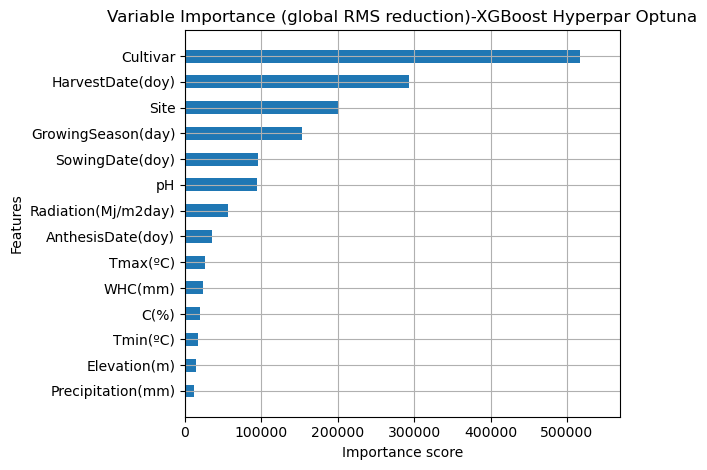

In [30]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

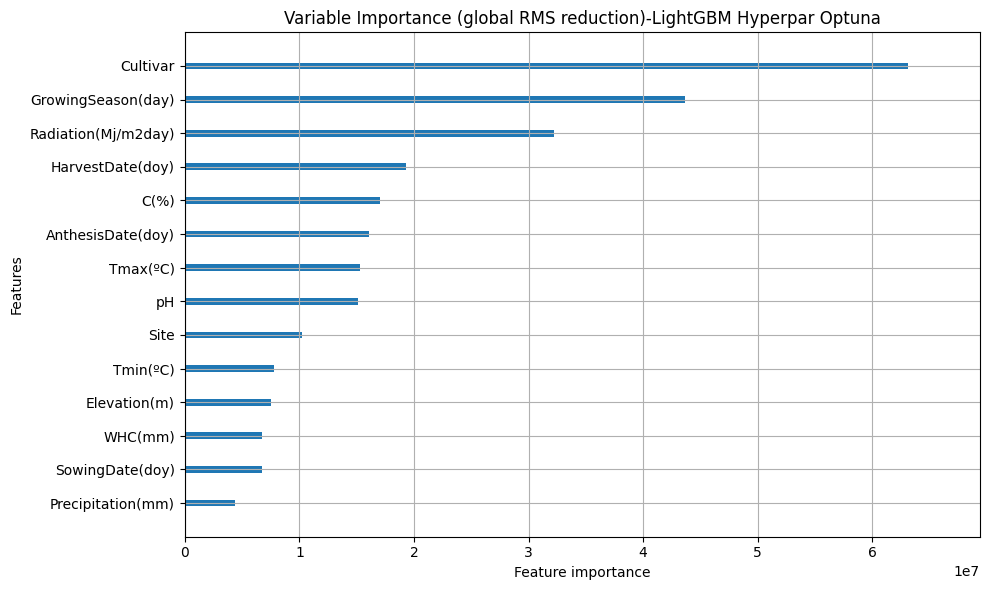

In [15]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


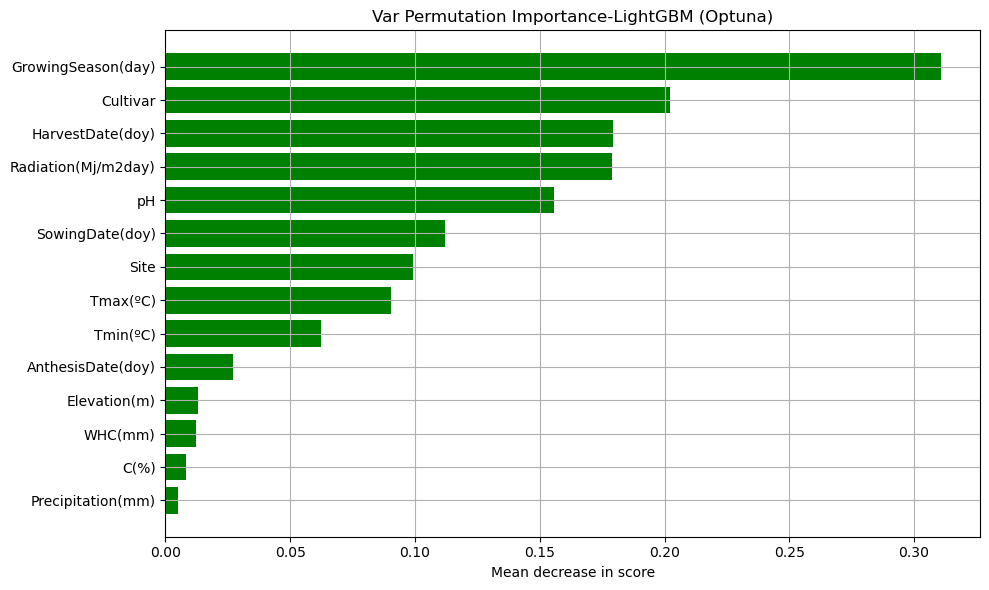

Var Permutation Importance-XGBoost (Optuna)


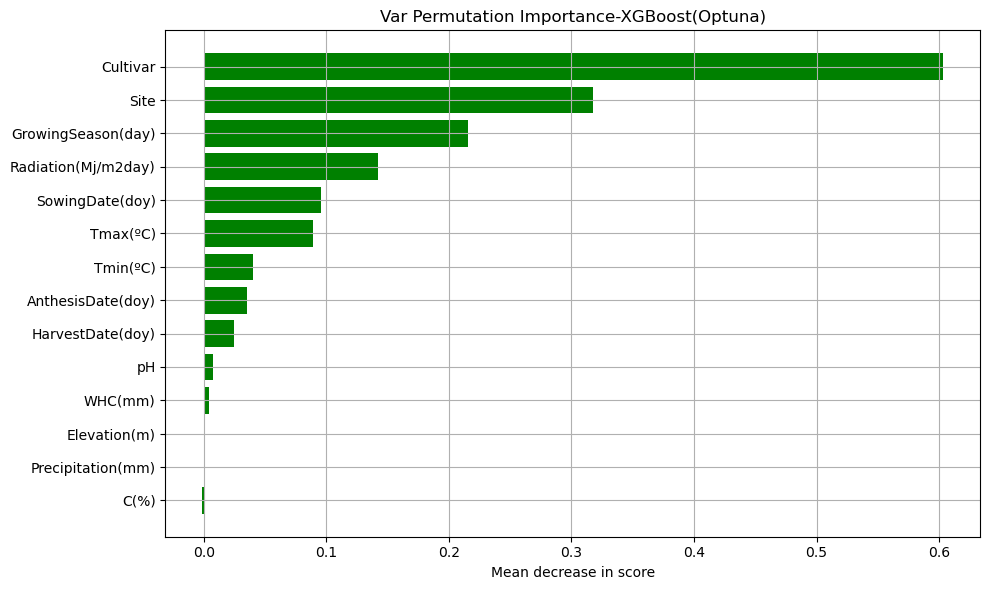

In [32]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


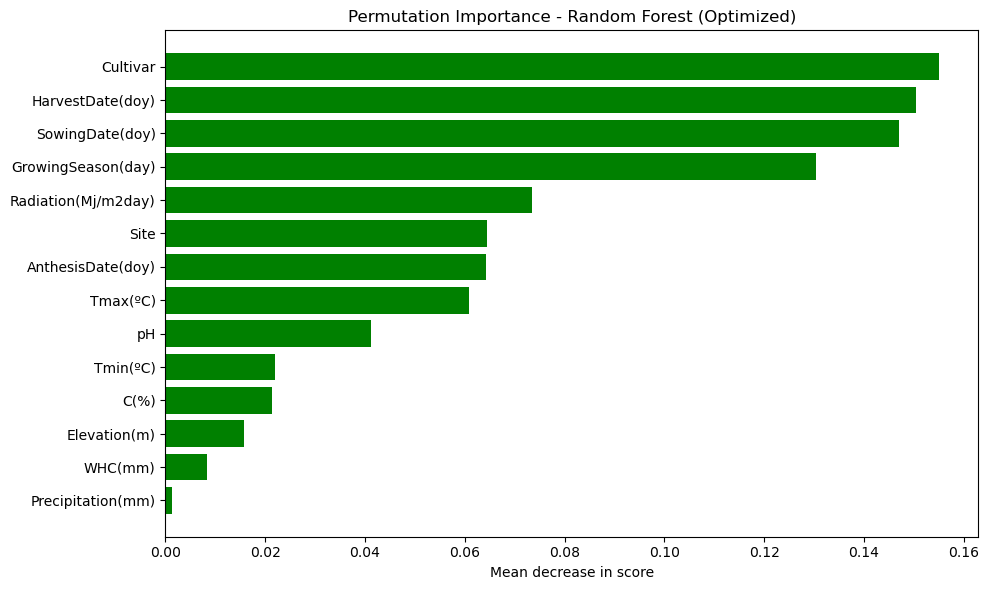

In [36]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'],color='green')
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



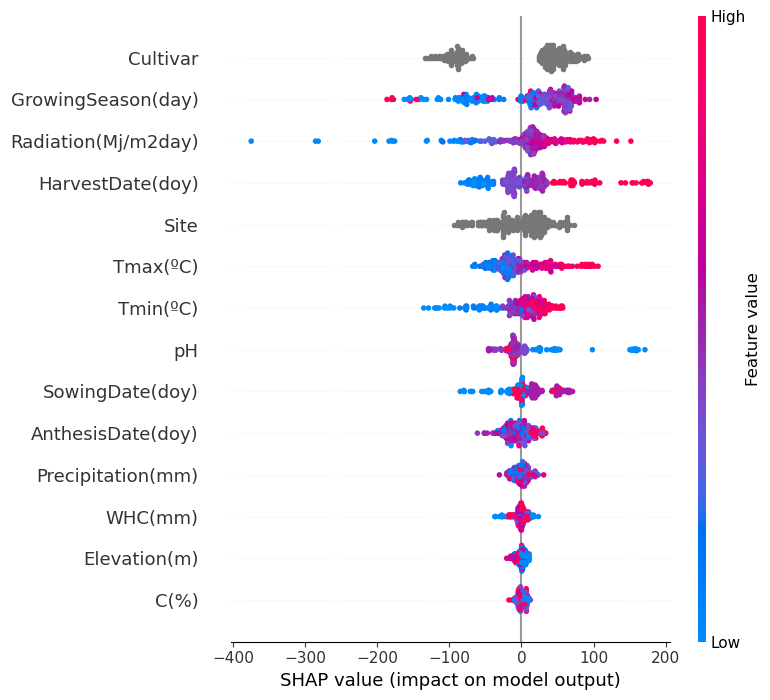

In [44]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

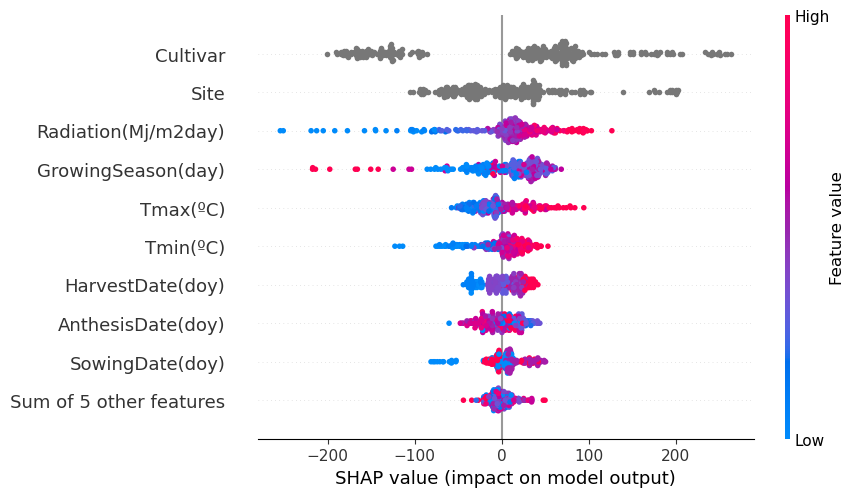

In [46]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [48]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


In [50]:
try:
  lgb_best.booster_.save_model("CP_lgb_best_model.txt")
except Exception as e:
    print("❌ Error saving the model LightGBM:", e)

## PREDICTION

In [52]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
import joblib
try:
    lgb_loaded = joblib.load("lgb_best_model.pkl")
except Exception as e:
    print("❌ Error al cargar el modelo LightGBM:", e)
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

columnas = ['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)','Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)','GrowingSeason(day)']

datos = [['Barcia','A200',25,21,56.6,20.5,16.7,90,1.8999999999999997,5.200000000000003,133,228.70531400966183,250,117]]

print(len(columnas))
print(len(datos))

# Crear DataFrame
X_nuevos_datos = pd.DataFrame(datos, columns=columnas)
X_nuevos_datos["Site"] = X_nuevos_datos["Site"].astype("category")
X_nuevos_datos["Cultivar"] = X_nuevos_datos["Cultivar"].astype("category")

# Reemplazar X_nuevos_datos por datos reales
y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
print(y_pred_lgb)
print(y_pred_xgb)

14
1
[1061.59393193]
[1032.9807]


### HAMZA / ANAS CODE

[I 2025-08-15 23:14:13,536] A new study created in memory with name: MLP_kgCP/ha
[I 2025-08-15 23:14:19,822] Trial 0 finished with value: 88.63181933993499 and parameters: {'h1': 65, 'use_h2': 1, 'h2': 19, 'alpha': 0.00038062792423346626, 'lr': 0.00013781054138513855, 'activation': 'relu', 'batch_size': 64}. Best is trial 0 with value: 88.63181933993499.
[I 2025-08-15 23:14:22,138] Trial 1 finished with value: 61.608113410476946 and parameters: {'h1': 99, 'use_h2': 0, 'alpha': 6.418172202772326e-05, 'lr': 0.009459639249730825, 'activation': 'relu', 'batch_size': 256}. Best is trial 1 with value: 61.608113410476946.
[I 2025-08-15 23:14:26,576] Trial 2 finished with value: 147.69552334795 and parameters: {'h1': 60, 'use_h2': 1, 'h2': 44, 'alpha': 0.014624674553312726, 'lr': 0.006261742170600788, 'activation': 'tanh', 'batch_size': 128}. Best is trial 1 with value: 61.608113410476946.
[I 2025-08-15 23:14:28,332] Trial 3 finished with value: 58.2647395638801 and parameters: {'h1': 48, 'use


MLP (kgCP/ha)
R2:   0.9662
RMSE: 43.7147
MAE:  31.9737
MAPE: 3.30%


,feature,importance
25,num__kgDM/ha,535.621177
26,num__UFL/ha,323.351932
5,cat__Site_Sarria,131.988450
12,cat__Cultivar_G400,129.071943
11,cat__Cultivar_G300,126.245970
4,cat__Site_Ribadeo,116.126054
6,cat__Site_Villaviciosa,111.007080
21,num__SowingDate(doy),110.822635
0,cat__Site_Barcia,108.836254
20,num__pH,97.711530


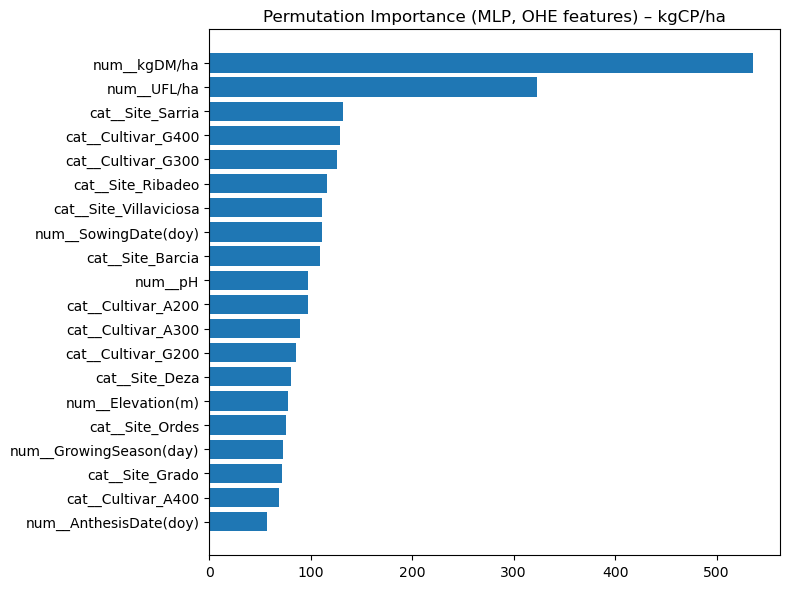

Saved: models/mlp_cp.pkl


In [57]:
import os, joblib, numpy as np, pandas as pd, optuna
from IPython.display import display
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

DATA_PATH = "260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx"
if 'df' not in globals():
    df = pd.read_excel(DATA_PATH)

objective_var = 'kgCP/ha'

cat_cols = [c for c in df.columns if c.lower() in ('site','cultivar')]
num_cols = [c for c in df.columns if c not in cat_cols + [objective_var]]

X = df[cat_cols + num_cols].copy()
y = df[objective_var].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def preprocessor():
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    return ColumnTransformer([('cat', ohe, cat_cols), ('num', StandardScaler(), num_cols)], remainder='drop')

def make_pipe(hidden=(128,64), alpha=1e-3, lr=1e-3, act='relu', batch=128):
    return Pipeline([('prep', preprocessor()),
                     ('model', MLPRegressor(hidden_layer_sizes=hidden, alpha=alpha,
                                            learning_rate_init=lr, activation=act,
                                            batch_size=batch, max_iter=1000, random_state=42))])

def objective(trial):
    h1 = trial.suggest_int('h1', 32, 256, log=True)
    use_h2 = trial.suggest_categorical('use_h2', [0,1])
    hidden = (h1,) if use_h2==0 else (h1, trial.suggest_int('h2', 16, 256, log=True))
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    lr    = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    act   = trial.suggest_categorical('activation', ['relu','tanh'])
    batch = trial.suggest_categorical('batch_size', [32,64,128,256])
    pipe  = make_pipe(hidden, alpha, lr, act, batch)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    s = cross_val_score(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1).mean()
    return -s

study = optuna.create_study(direction='minimize', study_name=f"MLP_{objective_var}")
study.optimize(objective, n_trials=40, show_progress_bar=False)
p = study.best_params
hidden = (p['h1'],) if p['use_h2']==0 else (p['h1'], p['h2'])

pipe = make_pipe(hidden, p['alpha'], p['lr'], p['activation'], p['batch_size'])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae = float(mean_absolute_error(y_test, y_pred))
mape = float(np.mean(np.abs((y_test - y_pred) / np.clip(y_test, 1e-9, None))) * 100)

print(f"\nMLP ({objective_var})")
print(f"R2:   {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Xt_test = pipe.named_steps['prep'].transform(X_test)
est = pipe.named_steps['model']
pi = permutation_importance(est, Xt_test, y_test, n_repeats=10, random_state=42, scoring='neg_root_mean_squared_error')
feat_names = pipe.named_steps['prep'].get_feature_names_out()
imp_df = pd.DataFrame({'feature': feat_names, 'importance': pi.importances_mean}).sort_values('importance', ascending=False).head(20)
display(imp_df)

plt.figure(figsize=(8, 6))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.title(f'Permutation Importance (MLP, OHE features) – {objective_var}')
plt.tight_layout()
plt.show()

os.makedirs('models', exist_ok=True)
short = {'kgDM/ha':'dm','UFL/ha':'ufl','kgCP/ha':'cp'}[objective_var]
out_path = f"models/mlp_{short}.pkl"
joblib.dump(pipe, out_path)
print(f"Saved: {out_path}")
